# Predicting Human Gait Cycles Using Accelerometer Data

## Background

The human walking is a periodic and repetitive movement of the body segments. A cycle is measured from one leg's heel strick (ground contact) to the same leg's next heel strike. http://www.mdpi.com/1424-8220/15/11/27738/pdf And one gait segment can be classified into the stance and the swing phase. it can be further divided into 4, 6, or even 8 phases.

This project used accelerometer data to segment and predict human gait cycles into 2 phases - heel strike (HS) and toe off (TO).


## Libraries

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import preprocessing

# import glob, os
# from random import shuffle as shuffle_array
# from sklearn.model_selection import StratifiedKFold

# import keras
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Activation, Flatten,  Convolution1D,Convolution2D, MaxPooling2D , AveragePooling2D
# from keras.utils import np_utils
# from keras.layers.core import Reshape

# import tensorflow as tf
# from keras.backend import tensorflow_backend as KTF

## Experimentation - Feature Selection 

Because of the constraint of time, labor and equipments, 2 participants with Android phones contributed to the data collection. Each participants was asked to walking and complete 6 steps and ends off foot flat standing on the ground (8 and 9 second data samples respectively), and 3-axis accelerometer data & 3-axis gyroscope data was recorded using a smart Android phone, which was put in the front pocket of the participant's right leg.

(An accelerometer is an electromechanical device used to measure acceleration forces. Such forces may be static, like the continuous force of gravity or, as is the case with many mobile devices, dynamic to sense movement or vibrations.
https://www.livescience.com/40102-accelerometers.html)


In [26]:
# Read in the data from text file
filename = "./Dataset1/sensorValues.txt"
data = np.genfromtxt(filename, dtype = "i", names=['_', '_', 'accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], delimiter="\t")

In [27]:
# Store the data in a pandas dataframe with only columns of interest
acc_gyro_data = pd.DataFrame(data)[['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']]

In [28]:
acc_gyro_data.head()

,accX,accY,accZ,gyroX,gyroY,gyroZ
0,-3804,526,7102,66,2,-31
1,-3802,522,7068,58,0,-22
2,-3816,506,7116,58,-8,-21
3,-3802,514,7092,50,-10,-37
4,-3786,536,7126,54,-11,-36


In [29]:
acc_gyro_data.shape

(940, 6)

### Normalization -> Discarded because it hides the neg-> pos -> neg trend in the x-axis

Each variable was normalized to have a min of 0 and max of 1.

s = (x - min)/(max - min)

In [30]:
# # Normalize the variables
# x = acc_gyro_data.values # returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df_normalized = pd.DataFrame(x_scaled)

In [31]:
# rename the columns 
# df_normalized.columns = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']

In [32]:
acc_gyro_data.head()

,accX,accY,accZ,gyroX,gyroY,gyroZ
0,-3804,526,7102,66,2,-31
1,-3802,522,7068,58,0,-22
2,-3816,506,7116,58,-8,-21
3,-3802,514,7092,50,-10,-37
4,-3786,536,7126,54,-11,-36


### Visualization

First let's take a look at the accelerometer data

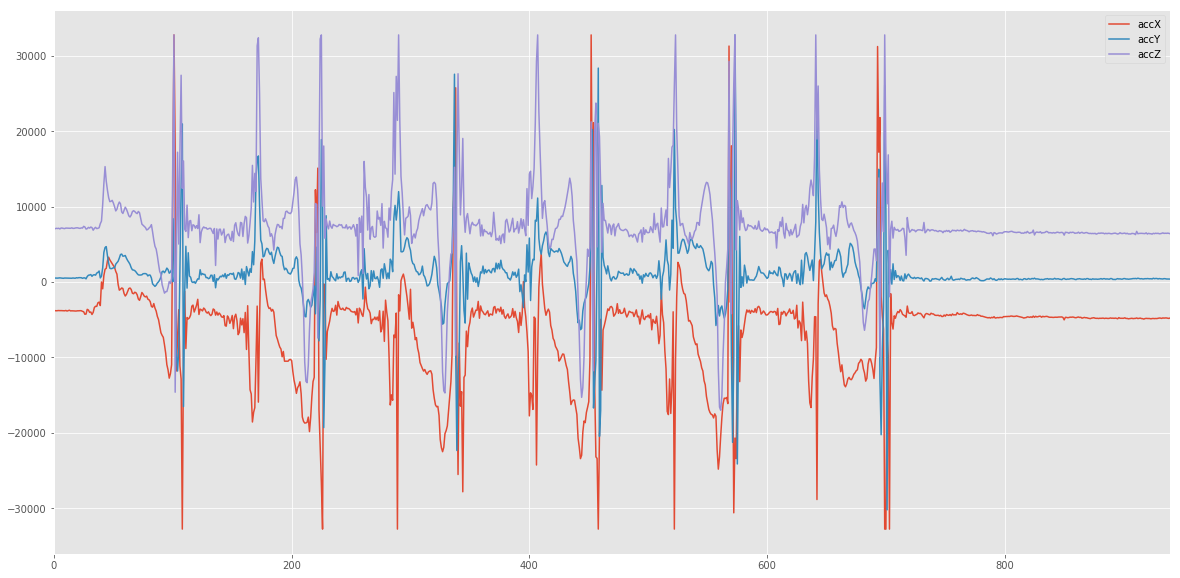

In [33]:
plt.style.use('ggplot')

acc_gyro_data[['accX', 'accY', 'accZ']].plot(figsize=(20, 10))

Because each participants was asked to walking and complete 6 steps and ends off foot flat standing on the ground, the end phase must be a standing position. Thus the peak right before that must have been a heel strike (HS). Therefore, we can inference that the 1st, 3rd, 5th, 7th, 9th, and 11th peak are HS events and the 2nd, 4th, 6th, 8th, 10th peak are toe off (TO) events.

Now, let's take a look at the gyroscope data.

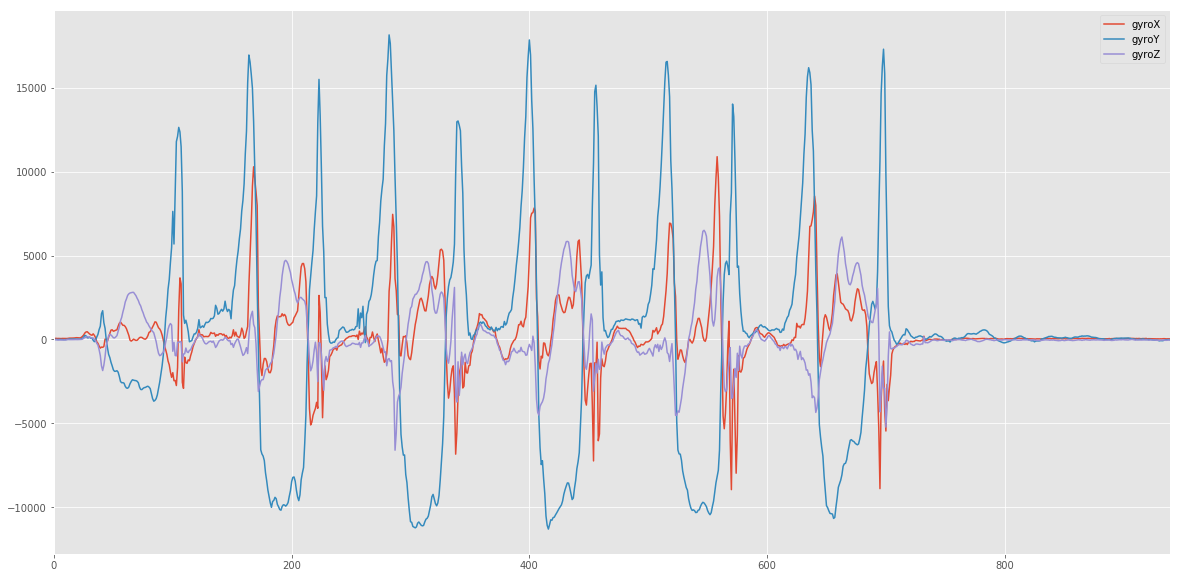

In [34]:
acc_gyro_data[['gyroX', 'gyroY', 'gyroZ']].plot(figsize=(20, 10))

It seems that gyroscope data has more noise and is less straightforward. But the 6 lowest points of the Y-axis data (blue line) clearly represents the 6 steps the participants were told to take and could be of help to our analysis.

Let's take a look at the processed data for participant #2.

In [35]:
# Read in the data of participant 1 from text file
filename2 = "./Dataset2/sensorValues.txt"
data2 = np.genfromtxt(filename, dtype = "i", names=['_', '_', 'accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_'], delimiter="\t")
# Store the data in a pandas dataframe with only columns of interest
acc_gyro_data2 = pd.DataFrame(data2)[['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']]

# Normalize the variables
# x2 = acc_gyro_data.values # returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# x2_scaled = min_max_scaler.fit_transform(x2)
# df_normalized2 = pd.DataFrame(x2_scaled)
# df_normalized2.columns = ['accX', 'accY', 'accZ', 'gyroX', 'gyroY', 'gyroZ']

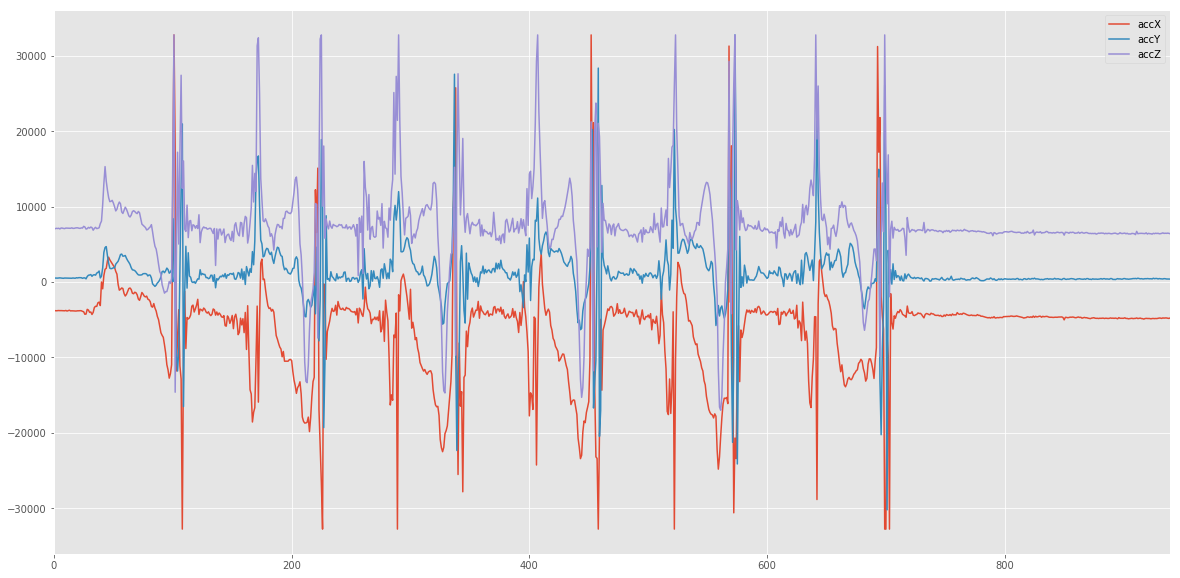

In [36]:
acc_gyro_data2[['accX', 'accY', 'accZ']].plot(figsize=(20, 10))

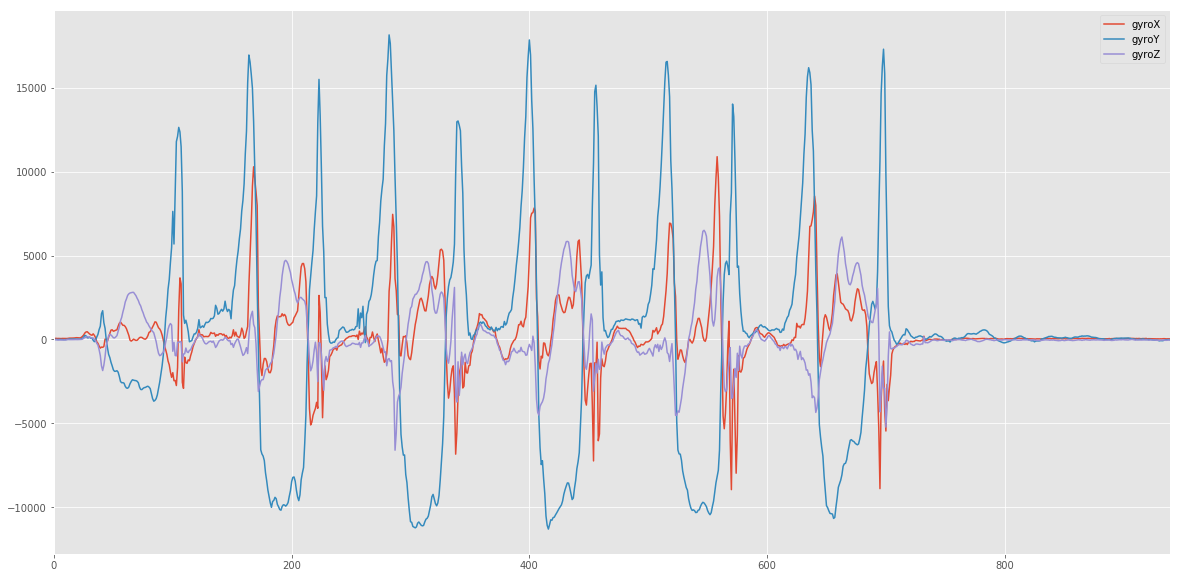

In [37]:
acc_gyro_data2[['gyroX', 'gyroY', 'gyroZ']].plot(figsize=(20, 10))

The accelerometer data is a little more noisy for the second participants but the trend is still very visable. 

After experimenting with accelerometer & gyroscope data with an Android phone, we decided to use accelerometer data and a bigger dataset was downloaded for further analysis from https://github.com/mareagait/gait-testlib/tree/master/test.

## Data Augmentation


In [38]:
# Accelerometer data stored as lists
# signals obtained from each individual axis of 3-axes accelerometer
accX = np.genfromtxt("accX.txt")
accY = np.genfromtxt("accY.txt")
accZ = np.genfromtxt("accZ.txt")

[Note] Is the dataset large enough?

high variance -> no

high bias -> yes


In [39]:
df = pd.DataFrame(np.column_stack((accX, accY, accZ)), columns = ['accX', 'accY', 'accZ'])

In [40]:
# Checking dataset size`
df.shape

(22701, 3)

In [41]:
df.head()

,accX,accY,accZ
0,1.412,-17.725,-12.706
1,0.471,-17.882,-12.706
2,-0.471,-18.510,-13.647
3,-2.196,-19.137,-13.176
4,-9.255,-20.549,-13.647


In [10]:
# # Normalize the variables
# X = df.values # returns a numpy array
# min_max_scaler = preprocessing.MinMaxScaler()
# X_scaled = min_max_scaler.fit_transform(X)
# df_normalized = pd.DataFrame(X_scaled)
# df_normalized.columns = ['accX', 'accY', 'accZ']

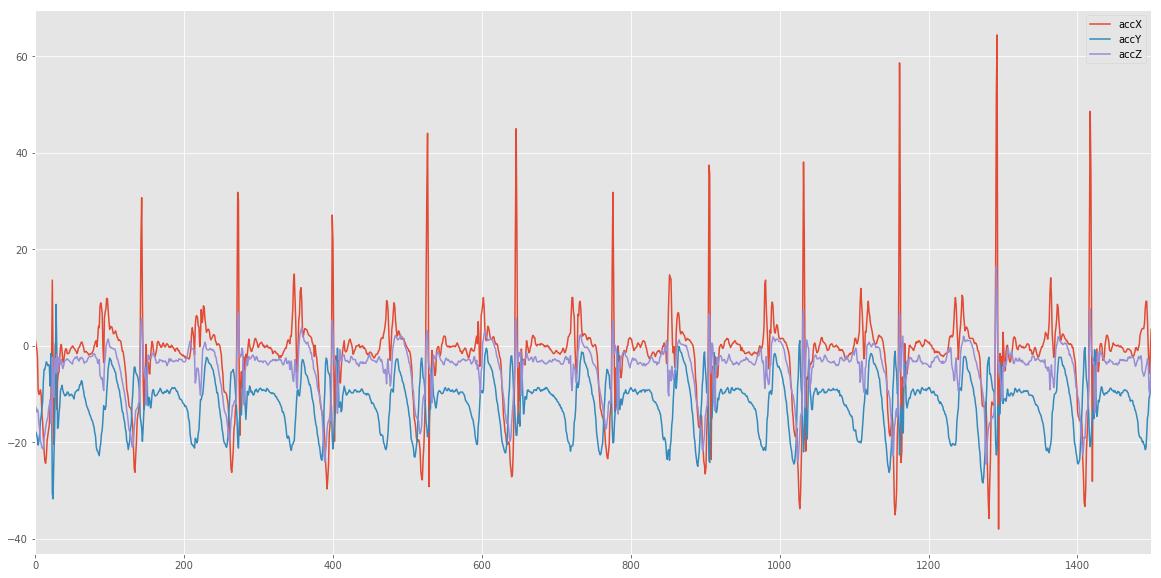

In [42]:
# Plot the first 1500 data entries
df.iloc[0:1500, :].plot(figsize=(20, 10))

We can see from the above graph that the larger dataset share similar trend as the small dataset we were looking into. And there is a clear trend for the acceleration on Y to be very high and X axis to go very low when HS happened. 

Before labelling the data by the trend, to remove the noise, we do a moving average with window size 5.

In [43]:
df_moving_avg = df.rolling(window = 5).sum()/5

In [44]:
# and remove the first 4 NaN data
df_moving_avg = df_moving_avg.iloc[4:]

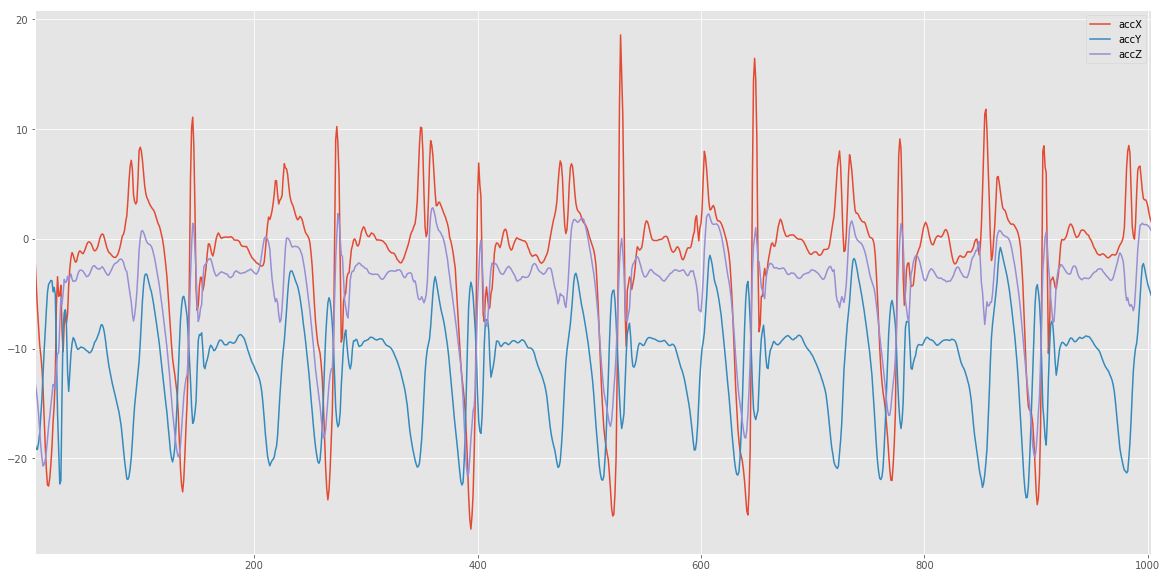

In [45]:
df_moving_avg.iloc[:1000,].plot(figsize=(20, 10))

## Manually Label the data - Simple Threshold 


Let's try to just predict HS if accY < -15 and accX > 10, and TO if accY > -5 and accX > 5 with some small random nuber added to them.

The numbers come from visually examination and experimentation (we want similar number of TO & HS events). 

In [55]:
# Predict HS if accY > 0.6 or accX < 0.2
np.random.seed(21)  # for reproducibility
df_moving_avg['event'] = ['HS' if v1 + np.random.rand(1)*0.1 < - 15 and v2  + np.random.rand(1)*0.1 > 10 \
                          else ('TO' if v1 + np.random.rand(1)*0.1 > -5 and v2 + np.random.rand(1)*0.1 > 5 else 'Other') \
                          for v1, v2 in zip(df_moving_avg['accY'], df_moving_avg['accX'])]

# df_moving_avg['event'] = ['HS' if v1 > 0.65 and v2 < 0.2 \
#                           else ('TO' if v1  > 0.7 and v2  > 0.4 else 'Other') \
#                           for v1, v2 in zip(df_moving_avg['accY'], df_moving_avg['accX'])]

I understand this is not the optima solution to the labeling procedure, however, this is probably the best we can do so far. Let's take a look at what our labels look like.

In [56]:
pd.Series.value_counts(df_moving_avg['event'])

Other    22039
TO         335
HS         323
Name: event, dtype: int64

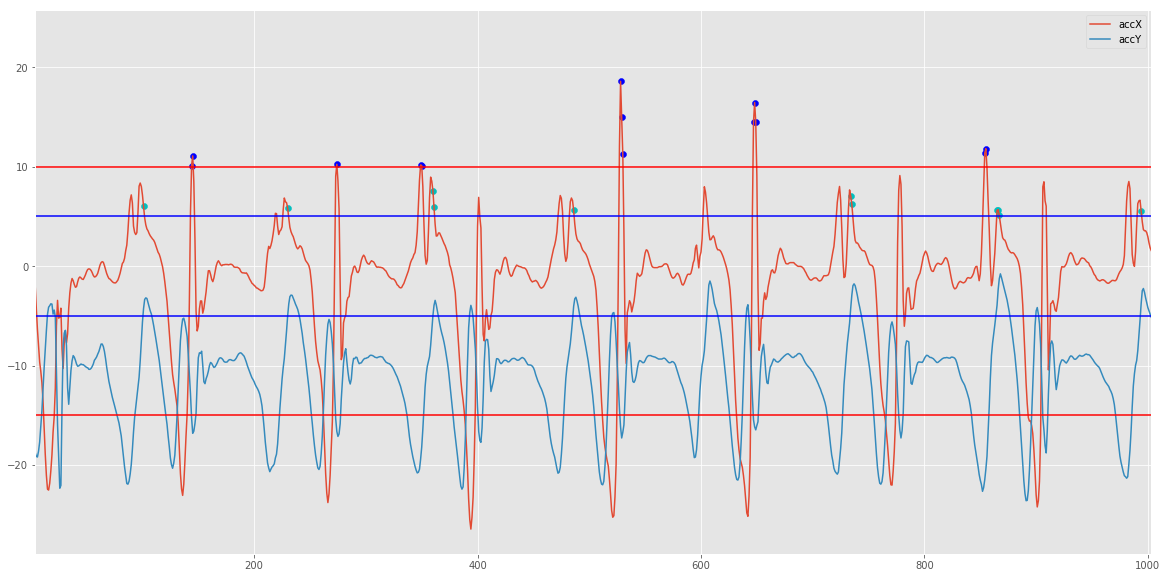

In [59]:
fig = plt.figure()
ax = df_moving_avg.iloc[:1000, 0:2].plot(figsize = (20, 10))
plt.axhline(y=-15, color='r', linestyle='-')
plt.axhline(y=10, color='r', linestyle='-')
plt.axhline(y=-5, color='b', linestyle='-')
plt.axhline(y=5, color='b', linestyle='-')


s1 = (df_moving_avg['event'] == 'HS')
s2 = (df_moving_avg['event'] == 'TO')
plt.scatter(df_moving_avg.index[s1], df_moving_avg['accX'][s1], marker='o', color = 'b')
plt.scatter(df_moving_avg.index[s2], df_moving_avg['accX'][s2], marker='o', color = 'c')

plt.show()

## Modeling



Let's train 3 seperate models in parrallel.

Output Arguments:

HS - vector containing sample numbers of Heel-Strike occurences

TO - vector containing sample numbers of Toe-Off occurences


### Train/Dev Set

In [93]:
# Divide the training data into 80% training & 20% development set

n = df_moving_avg.shape[0]
split_point = int(n * 0.8)
train, dev = df_moving_avg[:split_point], df_moving_avg[split_point:]

In [94]:
train.shape

(18157, 4)

In [95]:
dev.shape

(4540, 4)

In [96]:
dev.head()

,accX,accY,accZ,event
18161,0.0942,-8.7530,-3.7960,Other
18162,0.0314,-8.7844,-3.8274,Other
18163,-0.0314,-9.0040,-3.7332,Other
18164,-0.2196,-9.1922,-3.7018,Other
18165,-0.5648,-9.4430,-3.5450,Other


## Baseline - NB

In [66]:
train['event'] = [1 if x == 'HS' else(2 if x == 'TO' else 0) for x in train['event']]
dev['event'] = [1 if x == 'HS' else(2 if x == 'TO' else 0) for x in dev['event']]

In [97]:
train_X = train[['accX', 'accY', 'accZ']]
train_y = train['event']
dev_X = dev[['accX', 'accY', 'accZ']]
dev_y = dev['event']

In [100]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train_X, train_y)
GaussianNB(priors=None)
NBPred = clf.predict(dev_X)
test_error = len([(a, b) for a, b in zip(NBPred, dev_y) if a != b]) / len(dev_y)

# clf_pf = GaussianNB()
# clf_pf.partial_fit(X, Y, np.unique(Y))

In [101]:
test_error

0.006828193832599119

### Model 1 - HMM




In [89]:
from hmmlearn import hmm

remodel = hmm.GaussianHMM(n_components = 1, covariance_type = "full", n_iter = 1000)
remodel.fit(train)

GaussianHMM(algorithm='viterbi', covariance_type='full', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=1, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [90]:
train_error = len([(a, b) for a, b in zip(remodel.predict(train), train['event']) if a != b]) / len(train['event'])
train_error

0.0

In [91]:
hmmPred = remodel.predict(dev)

In [92]:
# Calculate the misclassification error
test_error = len([(a, b) for a, b in zip(hmmPred, dev['event']) if a != b]) / len(dev['event'])
test_error

0.0

obtain the general gait parameters and movement information on the body segments

We found out that there are 4 false positives and 6 false negatives in the development set. Let's calculate the F1 score.

### Model 2 - Shallow Neural Network

I built a 3-layer perceptron net. As it's a binary classification task, sigmoid functions were used in the output layer. And for the hidden layers the ReLU function was used. 

For the number of hidden units, I experimented with different settings and .


moving average technique

Regularization


In [106]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4, 3), random_state = 1)
clf.fit(train_X, train_y)                         

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(4, 3), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [107]:
train_err = len([(a, b) for a, b in zip(clf.predict(train_X), train_y) if a != b])
train_err

89

In [109]:
nnPred = clf.predict(dev_X)

In [110]:
error = len([(a, b) for a, b in zip(nnPred, dev_y) if a != b])
mis = float(error)/len(nnPred)
print(error, mis)

(25, 0.005506607929515419)


In [111]:
print([(a, b) for a, b in zip(nnPred, y_test) if a != b])

[('HS', 'Other'), ('HS', 'Other'), ('HS', 'Other'), ('HS', 'Other'), ('Other', 'TO'), ('Other', 'TO'), ('Other', 'TO'), ('Other', 'HS'), ('HS', 'Other'), ('HS', 'Other'), ('Other', 'TO'), ('HS', 'Other'), ('Other', 'HS'), ('TO', 'Other'), ('Other', 'TO'), ('HS', 'Other'), ('Other', 'TO'), ('Other', 'TO'), ('Other', 'TO'), ('HS', 'Other'), ('HS', 'Other'), ('HS', 'Other'), ('Other', 'TO'), ('HS', 'Other'), ('HS', 'Other')]


So far, because I am not able to manually lable the data and a simple linear function was given to calculate the threshold, just simple model would learn this decision boundary. So I tried to look into other labeled datasets available but couldn't find one. However, I encountered this much larger force & marker dataset (1.45G in total) with 22 participants at different speed and decided maybe thiscould be used to estimate the duration of each phase.

# Force & Marker Data 

The accelerometer data I got seemed to be not very informative. It's mainly the x axis that contributes to the gait segmentation. And y-axis and z-axis data is too similar.  

https://www.mad.tf.fau.de/research/activitynet/gaitphase-database/

force plates sampling at 1000 Hz were used for data acquisition


### Force Data

Force plate 1 (FP1) corresponds to the left foot, force plate 2 (FP2) to the right foot. The ordering of the columns is as follows:
FP1 x, FP2 x, FP1 y, FP2 y, FP1 z, FP2 z

### Marker Data
The markers are named according to the foot side, anatomical position and the di- rection: [L/R] [Position] [x/y/z] and occur as columns in the following order:
L FCC x, L FM1 x, L FM2 x, L FM5 x, R FCC x, R FM1 x, R FM2 x, R FM5 x, L FCC y, L FM1 y, L FM2 y, L FM5 y, R FCC y, R FM1 y, R FM2 y, R FM5 y, L FCC z, L FM1 z, L FM2 z, L FM5 z, R FCC z, R FM1 z, R FM2 z, R FM5 z

marker data with a cutoff frequency of 6Hz

x: posterior-anterior direction

y: right-left direction

z: inferior superior (vertical) direction

The objective of this study was to evaluate the percentage duration of the gait sub phases stance, loading response, mid stance, terminal stance, pre swing and swing as dependency on walking speed using an infrared cinematography system and an instrumented split-belt treadmill. Thus, a reference data set based on a large amount of steps under well controlled conditions is presented.


In [5]:
import os
import csv
filepath = './GaitPhaseDatabase/data/'
force_columns = ['FP1_x', 'FP2_x', 'FP1_y', 'FP2_y', 'FP1_z', 'FP2_z']
data_name = {'0.6': 'force_06', '0.7': 'force_07', '0.8': 'force_08', '0.9': 'force_09', \
             '1.0': 'force_10', '1.1': 'force_11', '1.2': 'force_12', '1.3': 'force_13', \
             '1.4': 'force_14', '1.5': 'force_15', '1.6': 'force_16', '1.7': 'force_17', }

for j in np.arange(0.6, 1.7, 0.1):
    name = data_name[str(j)]
    exec(name + " = pd.DataFrame(columns = force_columns)")
    subject = range(1, 23)
    subject = subject[:3]+subject[4:]
    for i in subject:
        filename = filepath + 'GP' + str(i) + '_' + str(j) + '_force.csv'
        exec(name + " = " + name + ".append(pd.read_csv(filename, sep = ','), ignore_index=True)")
    print("finished reading force data with speed " + str(j) + ", stored in dataframe " + name)

finished reading force data with speed 0.6, stored in dataframe force_06
finished reading force data with speed 0.7, stored in dataframe force_07
finished reading force data with speed 0.8, stored in dataframe force_08
finished reading force data with speed 0.9, stored in dataframe force_09
finished reading force data with speed 1.0, stored in dataframe force_10
finished reading force data with speed 1.1, stored in dataframe force_11
finished reading force data with speed 1.2, stored in dataframe force_12
finished reading force data with speed 1.3, stored in dataframe force_13
finished reading force data with speed 1.4, stored in dataframe force_14
finished reading force data with speed 1.5, stored in dataframe force_15
finished reading force data with speed 1.6, stored in dataframe force_16


We can see from the visualization below that the curve has a very clear trend.

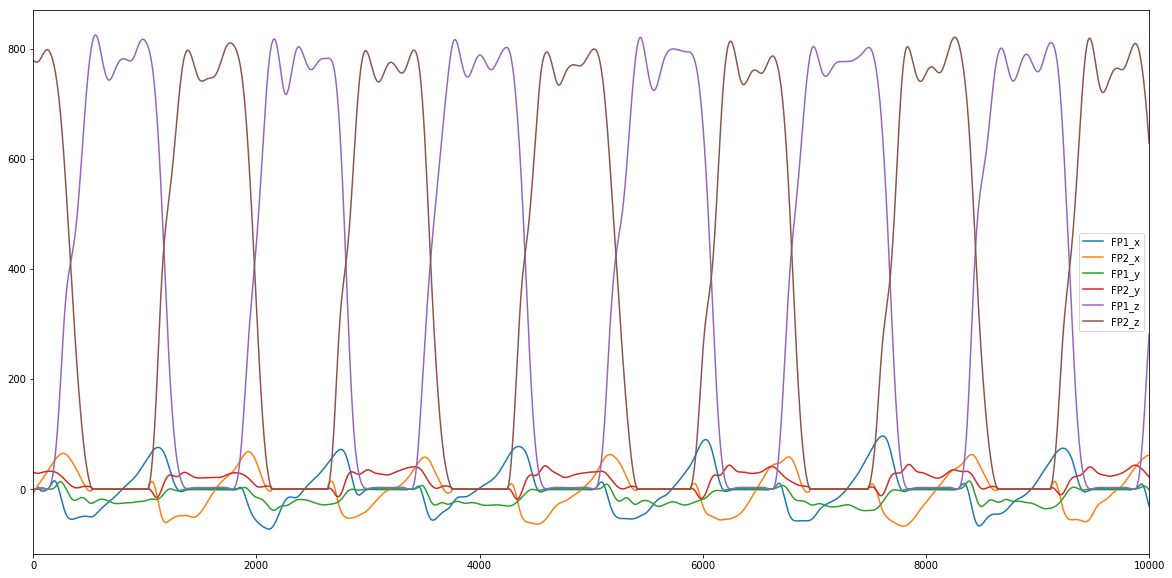

In [5]:
force_06.iloc[0:10000, ].plot(figsize=(20, 10))

After examine the z axis value, which seems to have the most variance, we found out that the frequency of each peak goes higher when the speed increased but the peak value doesn't really increase a lot.

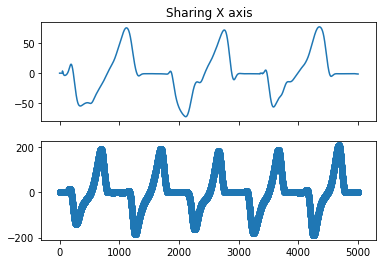

In [20]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(force_06.index.values[:5000], force_06['FP1_z'].iloc[:5000,])
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(force_16.index.values[:5000], force_16['FP1_z'].iloc[:5000,])

However, for x axis values, both the frequency and the peak value increase as the speed goes up.

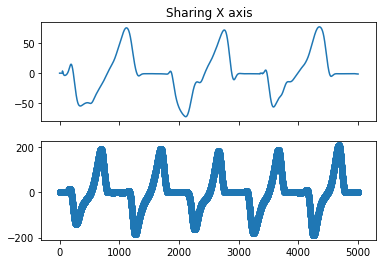

In [21]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(force_06.index.values[:5000], force_06['FP1_x'].iloc[:5000,])
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(force_16.index.values[:5000], force_16['FP1_x'].iloc[:5000,])

The trend is less clear in the y axis, as we expected. The right-left direction doesn't really affect one's walking speed.


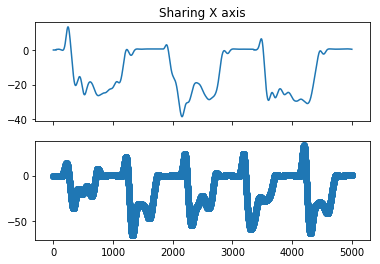

In [22]:
# Two subplots, the axes array is 1-d
f, axarr = plt.subplots(2, sharex=True)
axarr[0].plot(force_06.index.values[:5000], force_06['FP1_y'].iloc[:5000,])
axarr[0].set_title('Sharing X axis')
axarr[1].scatter(force_16.index.values[:5000], force_16['FP1_y'].iloc[:5000,])

So, I would go with the FP1_x attribute. 

Now let's label each dataframe with a reasonable threshold. We would be doing that by finding the minimum of peaks in 

In [222]:
from scipy.signal import argrelextrema

x = force_06['FP1_x'].values

In [234]:
from bisect import bisect

# For each local maximum, find the 2 nearest local maximum and check the difference is larger than 70
def findLocalMax(FP1_x_array):
    maxInd = argrelextrema(FP1_x_array, np.greater)[0]
    for i in range(1, len(maxInd)-1):
        cur = FP1_x_array[maxInd[i]]
        prev = FP1_x_array[maxInd[i-1]]
        nex = FP1_x_array[maxInd[i+1]]
        if(cur - prev < 70 and cur - nex < 70):
            maxInd[i] = 0
    maxInd = [a for a in maxInd if a != 0]
    return maxInd

In [235]:
maxInd = findLocalMax(x)
len(maxInd)

223

In [216]:
sample_ind = [a for a in maxInd if a < 10000]
ind = force_06['FP1_x'].index.values
x = force_06['FP1_x'].values

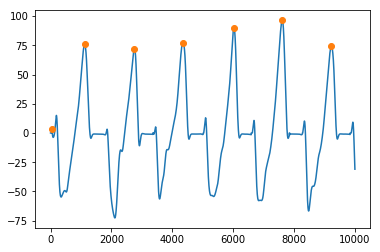

In [219]:
from pylab import *

plot(ind[:10000], x[:10000])
plot(ind[:10000][sample_ind], x[:10000][sample_ind], "o", label = "max")

Looks like we already successfully find the peak for each gait cycle. Let's label the data with 1 being a HS and 0 being anything else.

In [241]:
def labelHS(df, maxInd):
    df['event'] = 0
    df['event'][maxInd] = 1
    return df

In [243]:
force06 = labelHS(force_06, maxInd)

/Users/Tina/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [244]:
force_06['event'].sum()

223

And let's do that for all the dataframes.

In [254]:
max_07 = findLocalMax(force_07['FP1_x'].values)
force_07 = labelHS(force_07, max_07)
print(len(max_07), force_07['event'].sum())
max_08 = findLocalMax(force_08['FP1_x'].values)
force_08 = labelHS(force_08, max_08)
print(len(max_08), force_08['event'].sum())
max_09 = findLocalMax(force_09['FP1_x'].values)
force_09 = labelHS(force_09, max_09)
print(len(max_09), force_09['event'].sum())
max_10 = findLocalMax(force_10['FP1_x'].values)
force_10 = labelHS(force_10, max_10)
print(len(max_10), force_10['event'].sum())
max_11 = findLocalMax(force_11['FP1_x'].values)
force_11 = labelHS(force_11, max_11)
print(len(max_11), force_11['event'].sum())
max_12 = findLocalMax(force_12['FP1_x'].values)
force_12 = labelHS(force_12, max_12)
print(len(max_12), force_12['event'].sum())
max_13 = findLocalMax(force_13['FP1_x'].values)
force_13 = labelHS(force_13, max_13)
print(len(max_13), force_13['event'].sum())
max_14 = findLocalMax(force_14['FP1_x'].values)
force_14 = labelHS(force_14, max_14)
print(len(max_14), force_14['event'].sum())
max_15 = findLocalMax(force_15['FP1_x'].values)
force_15 = labelHS(force_15, max_15)
print(len(max_15), force_15['event'].sum())
max_16 = findLocalMax(force_16['FP1_x'].values)
force_16 = labelHS(force_16, max_16)
print(len(max_16), force_16['event'].sum())

(771, 771)
(933, 933)
(1074, 1074)
(1128, 1128)
(1163, 1163)
(1202, 1202)
(2483, 2483)
(1279, 1279)
(1319, 1319)


In [256]:
def plotSampleMax(df, maxInd):
    sample_ind = [a for a in maxInd if a < 10000]
    ind = df['FP1_x'].index.values
    x = df['FP1_x'].values
    plot(ind[:10000], x[:10000])
    plot(ind[:10000][sample_ind], x[:10000][sample_ind], "o", label = "max")


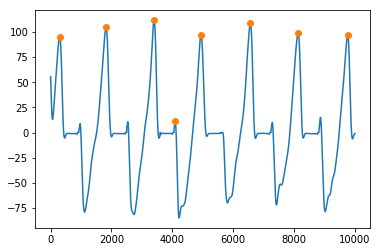

In [257]:
plotSampleMax(force_07, max_07)

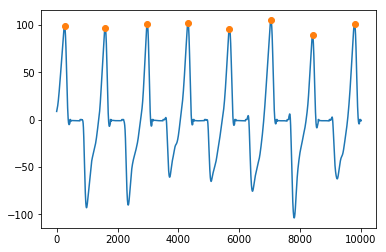

In [258]:
plotSampleMax(force_08, max_08)

After manually examine our results, everything seem find so far! Let's join all the dataframes from different speed together and name the new dataframe force_df.

In [259]:
force_df = force_06.append(force_07).append(force_08).append(force_09).append(force_10).append(force_11).append(force_12).append(force_13).append(force_14).append(force_15).append(force_16)

## Modeling

### Baseline - NB

In [274]:
# Divide the training data into 80% training & 20% development set
n = force_df.shape[0]
split_point = int(n * 0.8)
train, test = force_df[:split_point], force_df[split_point:]
train_size = train.shape[0]
test_size = test.shape[0]

In [275]:
train_X = train['FP1_x'].reshape((train_size, 1))
train_y = train['event'].reshape((train_size, 1))
test_X = test['FP1_x'].reshape((test_size, 1))
test_y = test['event'].reshape((test_size, 1))

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(train_X, train_y) 
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [ ]:
knnPred = knn.predict(dev_X)

In [ ]:
test_error = len([(a, b) for a, b in zip(knnPred, test_y) if a != b]) / len(testkrrrrrrr x  _y)
test_error

In [266]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train_X, train_y)
GaussianNB(priors=None)
NBPred = clf.predict(dev_X)
test_error = len([(a, b) for a, b in zip(NBPred, dev_y) if a != b]) / len(dev_y)
test_error

ValueError: Found input variables with inconsistent numbers of samples: [1, 11088000]

In [8]:
marker_columns = ['L_FCC_x', 'L_FM1_x', 'L_FM2_x', 'L_FM5_x', 'R_FCC_x', 'R_FM1_x', 'R_FM2_x', 'R_FM5_x', 'L_FCC_y',\
                  'L_FM1_y', 'L_FM2_y', 'L_FM5_y', 'R_FCC_y', 'R_FM1_y', 'R_FM2_y', 'R_FM5_y', 'L_FCC_z', 'L_FM1_z', \
                  'L_FM2_z', 'L_FM5_z', 'R_FCC_z', 'R_FM1_z', 'R_FM2_z', 'R_FM5_z']

data_name = {'0.6': 'marker_06', '0.7': 'marker_07', '0.8': 'marker_08', '0.9': 'marker_09', \
             '1.0': 'marker_10', '1.1': 'marker_11', '1.2': 'marker_12', '1.3': 'marker_13', \
             '1.4': 'marker_14', '1.5': 'marker_15', '1.6': 'marker_16', '1.7': 'marker_17', }

for j in np.arange(0.6, 1.7, 0.1):
    name = data_name[str(j)]
    exec(name + " = pd.DataFrame(columns = marker_columns)")
    subject = range(1, 23)
    subject = subject[:3]+subject[4:]
    for i in subject:
        filename = filepath + 'GP' + str(i) + '_' + str(j) + '_marker.csv'
        exec(name + " = " + name + ".append(pd.read_csv(filename, sep = ','), ignore_index=True)")
    print("finished reading marker data with speed " + str(j) + ", stored in dataframe " + name)

finished reading marker data with speed 0.6, stored in dataframe marker_06
finished reading marker data with speed 0.7, stored in dataframe marker_07
finished reading marker data with speed 0.8, stored in dataframe marker_08
finished reading marker data with speed 0.9, stored in dataframe marker_09
finished reading marker data with speed 1.0, stored in dataframe marker_10
finished reading marker data with speed 1.1, stored in dataframe marker_11
finished reading marker data with speed 1.2, stored in dataframe marker_12
finished reading marker data with speed 1.3, stored in dataframe marker_13
finished reading marker data with speed 1.4, stored in dataframe marker_14
finished reading marker data with speed 1.5, stored in dataframe marker_15
finished reading marker data with speed 1.6, stored in dataframe marker_16


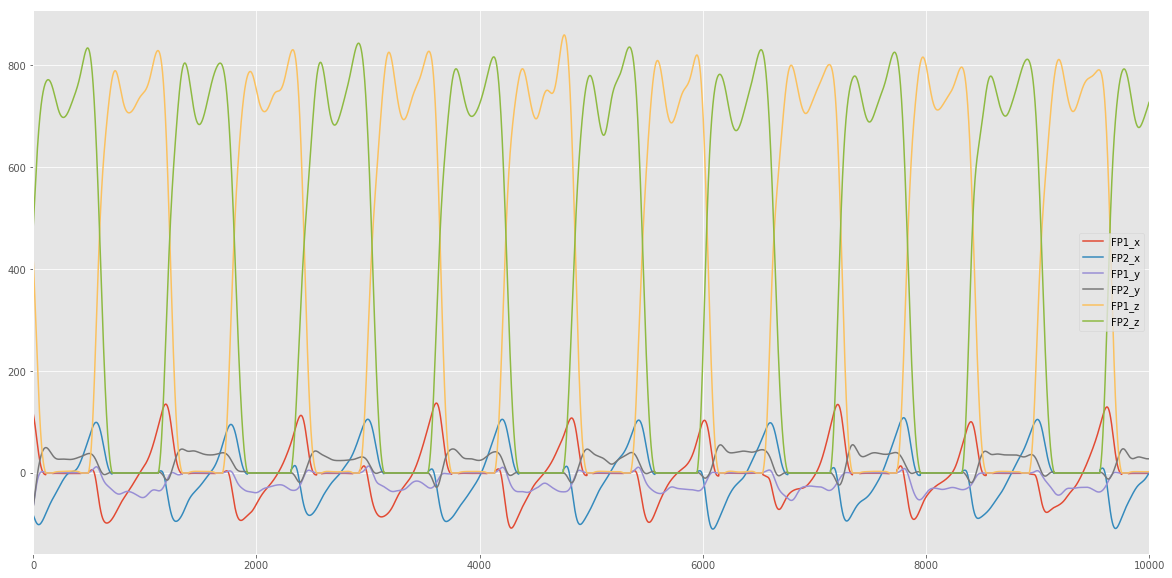

In [387]:

force_10.iloc[0:10000, :].plot(figsize=(20, 10))

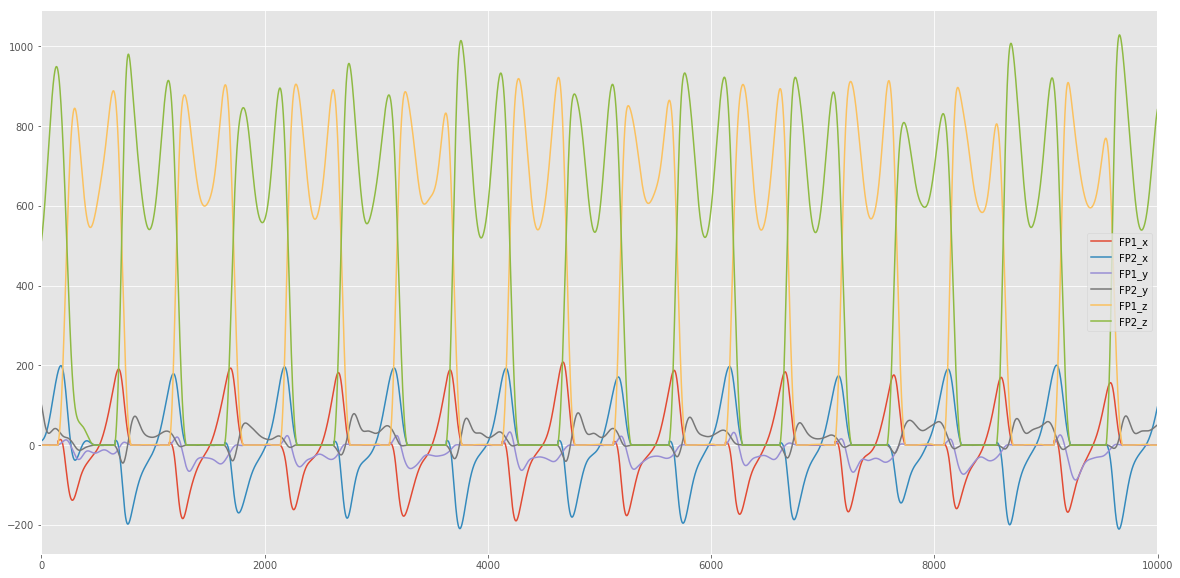

In [388]:
force_16.iloc[0:10000, :].plot(figsize=(20, 10))

As we can see from the visualization, with the speed of walking increasing, the vertical force increases during HS and TO, and the decrease trend between HS and TO are mroe obvious. 

For x axis, the force for the foot that was touching the ground has a very clear sin(x) shape. It goes from 0 to negative then back to 0 then all the way to positive and back to 0.

For the y axis, the force the foot that was in the air 

In [397]:
marker_07.head()

,L_FCC_x,L_FM1_x,L_FM2_x,L_FM5_x,R_FCC_x,R_FM1_x,R_FM2_x,R_FM5_x,L_FCC_y,L_FM1_y,...,R_FM2_y,R_FM5_y,L_FCC_z,L_FM1_z,L_FM2_z,L_FM5_z,R_FCC_z,R_FM1_z,R_FM2_z,R_FM5_z
0,0.628926,0.836563,0.840168,0.823058,0.888503,1.098850,1.094071,1.062056,0.561139,0.536024,...,0.387726,0.343356,0.084545,0.058607,0.066391,0.047475,0.090076,0.072617,0.079657,0.056256
1,0.626188,0.833782,0.837441,0.820210,0.894769,1.105314,1.100358,1.068544,0.561084,0.535987,...,0.386982,0.342608,0.084644,0.058504,0.066384,0.047470,0.088984,0.073667,0.080652,0.057093
2,0.623270,0.830821,0.834532,0.817181,0.901406,1.112139,1.106999,1.075402,0.561024,0.535950,...,0.386238,0.341866,0.084750,0.058400,0.066376,0.047465,0.087882,0.074838,0.081750,0.058004
3,0.620190,0.827697,0.831457,0.813991,0.908358,1.119264,1.113935,1.082572,0.560962,0.535914,...,0.385513,0.341151,0.084864,0.058298,0.066367,0.047459,0.086792,0.076135,0.082954,0.058986
4,0.616968,0.824431,0.828239,0.810662,0.915562,1.126620,1.121102,1.089989,0.560897,0.535879,...,0.384825,0.340482,0.084987,0.058198,0.066355,0.047454,0.085738,0.077561,0.084263,0.060038


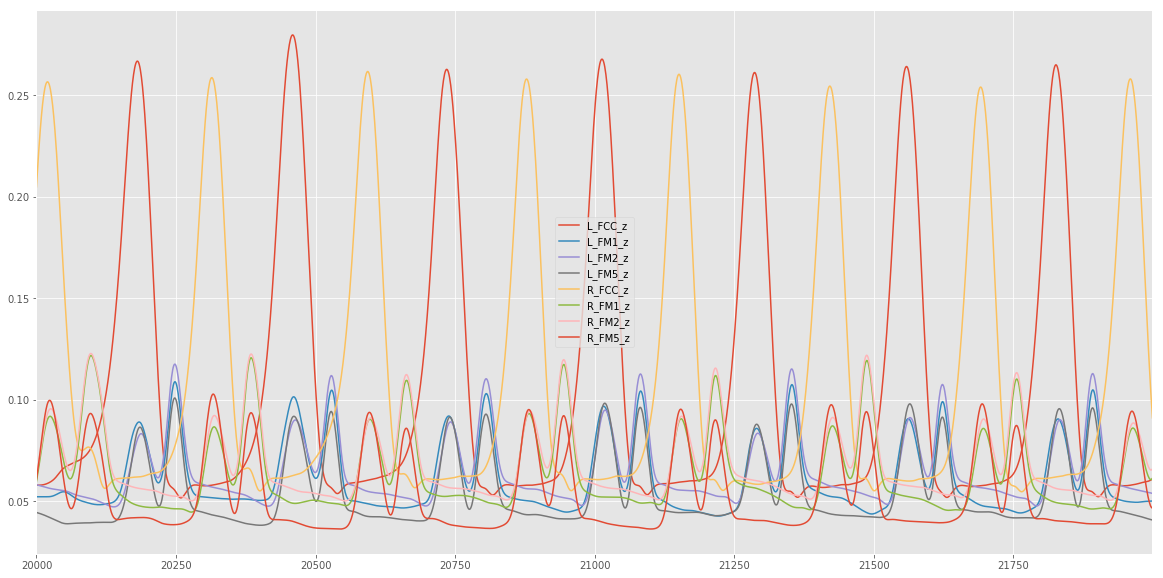

In [414]:
marker_07.iloc[20000:22000, 16:].plot(figsize=(20, 10))

In [402]:
marker_06.shape

(252000, 24)

In [403]:
force_06.shape

(1260000, 6)

It seems that each group of markers share very similar trend, so let's just pick one from each group. 

R_FM5_x, R_FM5_y, L_FFC_z

And plot again

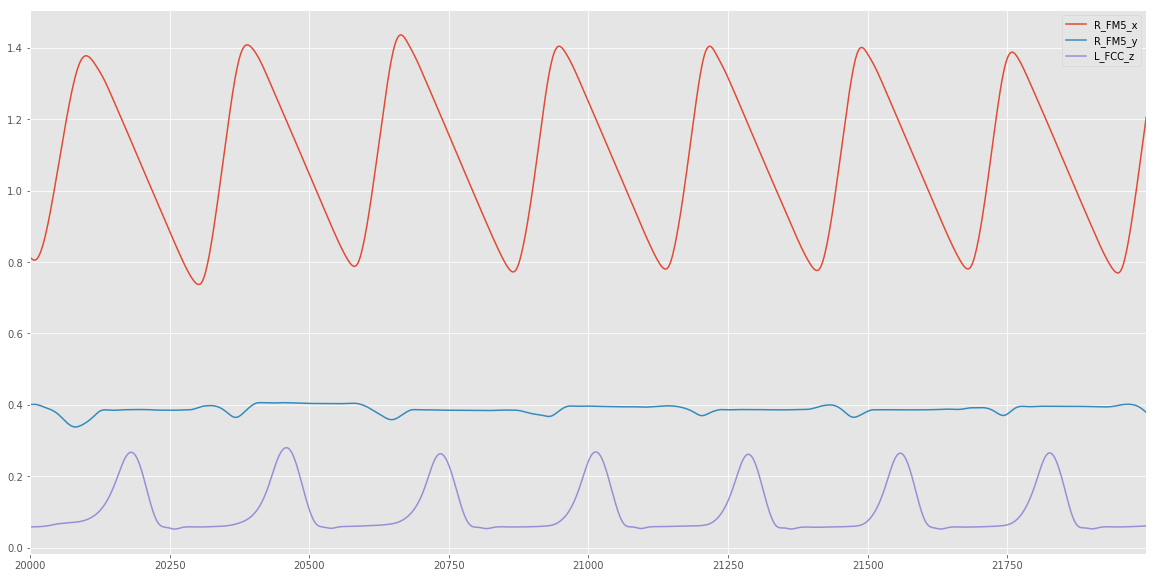

In [419]:
df = marker_07[['R_FM5_x', 'R_FM5_y', 'L_FCC_z']]
df.iloc[20000:22000, ].plot(figsize=(20, 10))

In [6]:
from __future__ import division
from numpy.fft import rfft
from numpy import argmax, mean, diff, log
from matplotlib.mlab import find
from scipy.signal import blackmanharris, fftconvolve
from time import time
import sys

import parabolic

In [14]:
X = marker_07.index.values
Y = marker_07[['R_FM5_y']].values.tolist()


In [10]:
def covariance(x, k):
    N = len(x) - k
    return (x[:-k] * x[k:]).sum() / N

def phd1(x):
    """Estimate frequency using Pisarenko Harmonic Decomposition"""
    r1 = covariance(x, 1)
    r2 = covariance(x, 2)
    a = (r2 + np.sqrt(r2 ** 2 + 8 * r1 ** 2)) / 4 / r1
    if a > 1:
        a = 1
    elif a < -1:
        a = -1
    return np.arccos(a)

def freq(x, sample_step=1, dt=1.0):
    """Estimate frequency using `phd1`"""
    omega = phd1(x[::sample_step])
    return omega / 2.0 / np.pi / sample_step / dt

In [15]:
freq(X)

0.00018304738057012572

ValueError: in1 and in2 should have the same dimensionality

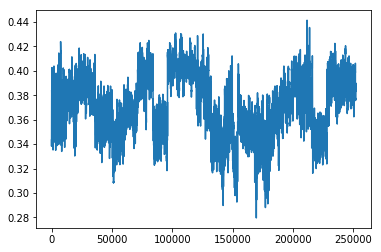

In [20]:
import urllib2
import scipy.signal as signal

plt.plot(Y)

peakind = signal.find_peaks_cwt(Y, np.array([len(Y)]), min_snr=5)
peakind = np.array(peakind)
print peakind

plt.stem(X[peakind], 1+0*peakind);

period = int(np.mean(np.diff(peakind)))
print "Period between peaks:", X[period]-X[0]

## Self-check

1. Dataset Augmentation

I really wanted to have a larger dataset but I don't have the equipment and time to gather more data by myself. I tried to contact the open-source MAREA gait database but haven't heard from them yet.

2. Multiplicity of models

I trained 3 models in parallel, however, they all use the same input, same attributes.

-> foot force data for neural network 


3. Visualization



4. Regularization

Regularization cannot save me. 

## Limitations

- Dataset
  - No labels
  - Normal walking and running in the sagittal plane on level ground
    - May not generalize when the walking speed changes
    - Haven't considered toe walkers
  - Only acclerometer data was used. Potential features include:
    - gyroscope data
    - foot angular velocity data
    - sensors on the shank, thigh and foot of both left & right side
    - video captures
  - Test on both healthy individuals and patients, different age groups
- Models
  - No ground truth values for HS and TO
  - There is no scientific evaluation method, evaluation was done visually



### Alternative dataset


1. MAREA

Requested access but haven't got


http://islab.hh.se/mediawiki/Gait_database

The Movement Analysis in Real-world Environments using Accelerometers - MAREA gait database was used. Accelerometers tend to be the most popular data source for gait partitioning problems becuase it's durable, readily available and inexpensive. 

The MAREA gait database comprises of gait activities in different real-world environments as shown in the table below. 20 healthy adults (12 males and 8 females, average age: 33.4 +- 7 years, average mass: 73.2 +- 10.9 kg, average height: 172.6 +- 9.5 cm) participated in the study. Each subject had a 3-axes Shimmer3 (Shimmer Research, Dublin, Ireland) accelerometer (+- 8g) attached to their waist, left wrist and left and right ankles using elastic bands and velcro straps. 

The above figure shows the position and orientation of each accelerometer at the beginning of each experiment. On the waist, the accelerometer X and Y axes were pointing to the lateral and downward direction, respectively. On the wrist and left ankle, the Z axis was pointing in the lateral direction while the Y axis was pointing downward and was aligned with the limb longitudinal axis. In order to simulate a lesser controlled scenario, the accelerometer on right ankle was positioned such that the Y axis was pointing downward but the Z axis was marginally disturbed such that it was not exactly perpendicular to the sagittal plane. 

The subjects were provided shoes that were instrumented with piezo-electric force sensitive resistors (FSRs), fixed at the extreme ends of the sole in order to provide the ground truth values for HS and TO. An external expansion board was used to synchronously collect the data from the FSRs on each foot and the respective ankle accelerometer, at a sampling frequency of 128Hz, and stored locally on the Shimmer3 microSD card. Due to the lack of a centralized data logger, the waist accelerometer was not in perfect synchronization with the ankle accelerometer.


2. The GaitPhase database consists of gait data from 21 subjects (10 male, 11 female, age: 23.8 yrs ± 3.3 yrs, height: 172.8 cm ± 9.4 cm, weight: 66.6 kg ± 10.9 kg; all values are mean ± standard deviation). In total, 25306 steps were acquired.
The performed excercise was walking on a split-belt treadmill at 12 different speeds in the interval [0.6, 1.7] m/s with 0.1 m/s increments for one minute at each speed.

https://www.mad.tf.fau.de/research/activitynet/gaitphase-database/


2. Graphic database

https://gait.fi.muni.cz/#database

3. Good research done in Java (data not available)

https://gitlab.fi.muni.cz/xbalazia/GaitRecognition/tree/master

4. Motion captured data

http://resources.mpi-inf.mpg.de/HDM05/

http://resources.mpi-inf.mpg.de/HDM05/07_MuRoClEbKrWe_HDM05.pdf


5. Motion Dataset

The format keeps an overall structure of the human body and holds estimated 3D positions of major anatomical landmarks as the person moves

https://gait.fi.muni.cz/#overview


## References


- Hebenstreit, F., Leibold, A., Krinner, S., Welsch, G., Lochmann, M., Eskofier, B.M. (2014) Are Relative Gait Phase Durations Speed Dependent?, submitted.

- Gait Partitioning Methods: A Systematic Review 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4732099/

- Weijun Tao 1, Tao Liu 2,*, Rencheng Zheng 3 and Hutian Feng 1 Gait Analysis Using Wearable Sensors

- Introduction of gait cycle https://www.physio-pedia.com/Gait

- A Neural Network-Based Gait Phase Classification Method Using Sensors Equipped on Lower Limb Exoskeleton Robots

- 

In [248]:
import warnings
warnings.filterwarnings('ignore')